In [1]:
import numpy as np
import profileclass
from dosematrix import DoseMatrix
import matplotlib.pyplot as plt
import PinnaclePlanarDose
import math
import os

In [8]:
def test_pdds():
    OF_medido = 1
    factorMC = 1.57
    path = os.path.join(os.getcwd(),"files")
    ficheroCuba = os.path.join(path, "Versa6MV_10x10_PDD.dat")
    # lee los datos del pdd de un fichero de texto
    array_txt = np.loadtxt(ficheroCuba, usecols=(0, 1), skiprows=0)
    # genera un objeto de la clase profileclass
    PerfilCuba = profileclass.Profile(array_txt)
    # aplica factor de escala a la dosis
    PerfilCuba.yscale = 0.01
    # obtiene el valor de dosis para una posición, en este caso el valor del PDD a 10 cm
    PDD10 = PerfilCuba.get_valfromposition(10)
    print("PDD(10) = %.3f" % PDD10)
    # Aplica factor de escala a la dosis
    PerfilCuba.yscale = PerfilCuba.yscale * OF_medido

    ficheroMC = os.path.join(path, "10x10_VersaMacarena-6MV_E6p2_EW0p5_Spot0p15_C0p05_1E8hist_300inst_PDD.txt")
    # lee el perfil de dosis del fichero
    array_txt = np.loadtxt(ficheroMC, usecols=(0, 1), skiprows=0)
    PerfilMC = profileclass.Profile(array_txt)
    # aplica factor de escala a dosis
    PerfilMC.yscale = factorMC
    # aplica factor de escala a posiciones para pasar de mm a cm
    PerfilMC.xscale = 0.1
    # lee los valores de incertidumbre del perfil, que están en la tercera columna
    array_txt = np.loadtxt(ficheroMC, usecols=(0, 2), skiprows=0)
    PerfilMC_unc = profileclass.Profile(array_txt)
    # aplica el mismo factor de escala al perfil de incertidumbres
    PerfilMC_unc.yscale = factorMC

    # representa graficamente los dos pdds
    plt.rcParams["figure.figsize"] = (12, 8)
    plt.errorbar(PerfilMC.get_positions(), PerfilMC.get_profilevalues(), yerr=PerfilMC_unc.get_profilevalues())
    plt.plot(PerfilCuba.get_positions(), PerfilCuba.get_profilevalues())
    plt.title('PDD 10x10, SSD = 100cm')
    plt.xlabel('cm')
    plt.legend(('Cuba', 'MC'), loc='upper right')
    plt.show()
    # calcula la relación entre los valores máximos de cada pdd
    print("DmaxCuba/DmaxMC = %.3f" % (PerfilCuba.get_maxval() / PerfilMC.get_maxval()))

In [3]:
def test_perfiles():
    OF_medido = 0.684
    factorMC = 1.57

    path = os.path.join(os.getcwd(),"files")
    ficheroCuba = os.path.join(path,"Versa6MV_1x1_Z10_YProf.dat")
    array_txt = np.loadtxt(ficheroCuba, usecols=(0, 1), skiprows=0)
    PerfilCuba = profileclass.Profile(array_txt)
    PDD10 = 0.674
    PerfilCuba.yscale = PerfilCuba.yscale * PDD10 * OF_medido
    S_Cuba = PerfilCuba.get_FWHM()
    PerfilCuba.normalize_cax()

    ficheroMC = os.path.join(path,"1x1_VersaMacarena-6MV_E6p2_EW0p5_Spot0p15_C0p05_4E8hist_100inst-F23_YProf_z10.txt")
    array_txt = np.loadtxt(ficheroMC, usecols=(0, 1), skiprows=0)
    PerfilMC = profileclass.Profile(array_txt)
    PerfilMC.yscale = factorMC
    PerfilMC.xscale = 0.1
    array_txt = np.loadtxt(ficheroMC, usecols=(0, 2), skiprows=0)
    PerfilMC_unc = profileclass.Profile(array_txt)
    PerfilMC_unc.yscale = factorMC
    # obtiene la FWHM
    S_MC = PerfilMC.get_FWHM()
    # normaliza el perfil al CAX
    PerfilMC.normalize_cax()

    plt.rcParams["figure.figsize"] = (12, 8)
    plt.errorbar(PerfilMC.get_positions(), PerfilMC.get_profilevalues(), yerr=PerfilMC_unc.get_profilevalues())
    plt.plot(PerfilCuba.get_positions(), PerfilCuba.get_profilevalues())
    plt.title('Y 1x1, SSD = 100cm, Depth = 10cm')
    plt.xlabel('cm')
    plt.legend(('Cuba', 'MC'), loc='upper right')
    plt.xlim(-5, 5)
    plt.show()

    # Calcula las posiciones del 50% izquierda y derecha del perfil
    print("MC:    L50 = %.2f  R50 = %.2f  FWHM = %.2f" % (
        PerfilMC.get_L50(), PerfilMC.get_R50(), PerfilMC.get_FWHM()))
    print("Cuba:  L50 = %.2f  R50 = %.2f  FWHM = %.2f" % (
        PerfilCuba.get_L50(), PerfilCuba.get_R50(), PerfilCuba.get_FWHM()))

In [4]:
def test_planardose():
    path = os.path.join(os.getcwd(), "files")
    perfil_file = os.path.join(path,"Perfil_Barras_DKS.txt")
    # lee la primera y segunda columna del fichero del perfil de dosis
    # se salta la primera linea.
    array_txt = np.loadtxt(perfil_file, usecols=(0, 1), skiprows=1)
    # crea un objeto de la clase profileclass
    perfil_Barras_DKS = profileclass.Profile(array_txt)
    # aplica un offset a las coordenadas de posicion
    perfil_Barras_DKS.xoffset = -98.5
    # aplica un factor de escala a la dosis
    perfil_Barras_DKS.yscale = 0.1

    planar_file = os.path.join(path,"BarPattern6MV_TG0p145.pnc")
    # crea un objeto planardose a partir del fichero de texto de pinnacle
    planarObj = PinnaclePlanarDose.PinnaclePlanarDose(planar_file)
    # obtiene el perfil de dosis central de la planardose en el eje Y
    perfil_Barras_Planar = planarObj.GetYcentralprofile()
    # Aplica un factor de escala a las coordenadas
    perfil_Barras_Planar.xscale = 10

    # representa graficamente la comparacion de ambos perfiles
    plt.rcParams["figure.figsize"] = (20, 10)
    plt.xlim(-120, 120)
    plt.plot(perfil_Barras_DKS.get_positions(), perfil_Barras_DKS.get_profilevalues())
    plt.plot(perfil_Barras_Planar.get_positions(), perfil_Barras_Planar.get_profilevalues())
    plt.title('Tongue and groove de 0.145')
    plt.ylabel('Dose (cGy)')
    plt.xlabel('mm')
    plt.legend(('Film', 'TPS'), loc='upper right')
    plt.show()


In [5]:
def test_dosematrix():
    path = os.path.join(os.getcwd(), "files")
    dmat = DoseMatrix(file_path=os.path.join(path,"20x20_6MV_SSD90.bindose"))

    perfil_pdd = dmat.get_dose_profile(idim=2,off1=0,off2=0, mode='D')
    perfil_pdd_unc = dmat.get_dose_profile(idim=2, off1=0, off2=0, mode='U')

    # representa graficamente los dos pdds
    plt.rcParams["figure.figsize"] = (12, 8)
    plt.errorbar(perfil_pdd.get_positions(), perfil_pdd.get_profilevalues(), yerr=perfil_pdd_unc.get_profilevalues())
    plt.title('PDD 20x20, SSD = 90cm')
    plt.xlabel('mm')
    plt.show()

PDD(10) = 0.674


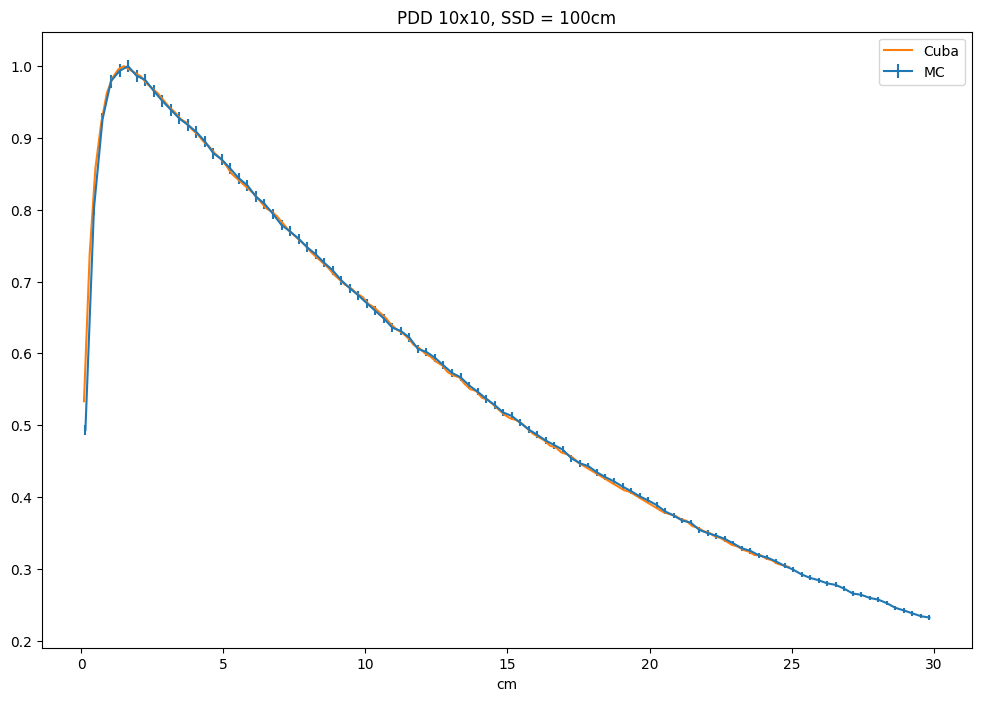

DmaxCuba/DmaxMC = 1.000


In [9]:
test_pdds()

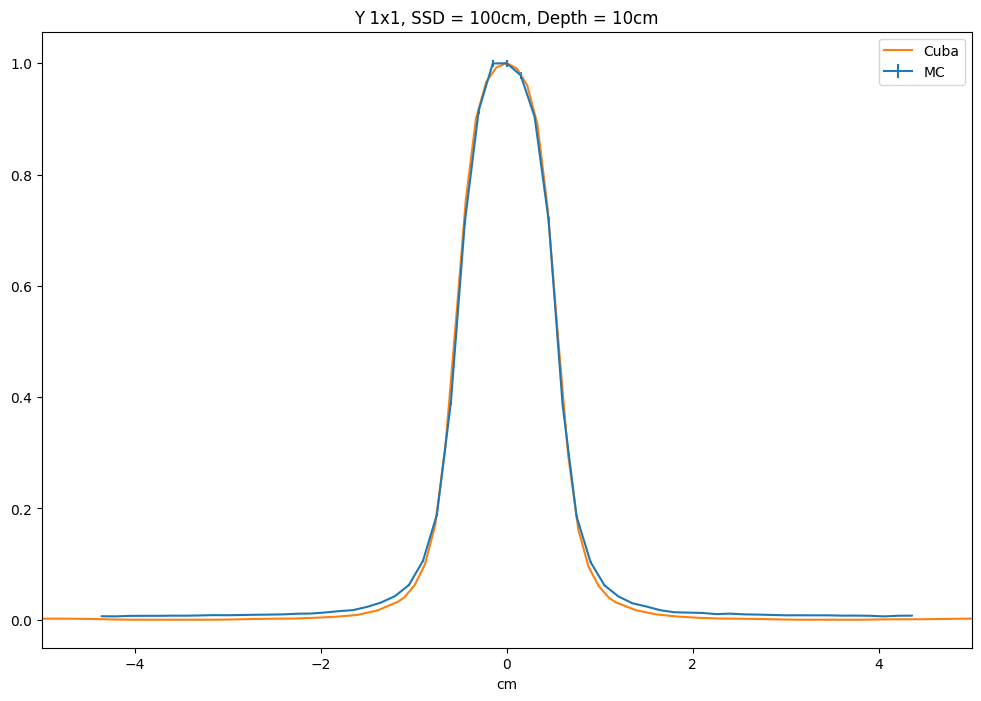

MC:    L50 = -0.55  R50 = 0.55  FWHM = 1.10
Cuba:  L50 = -0.56  R50 = 0.56  FWHM = 1.12


In [7]:
test_perfiles()

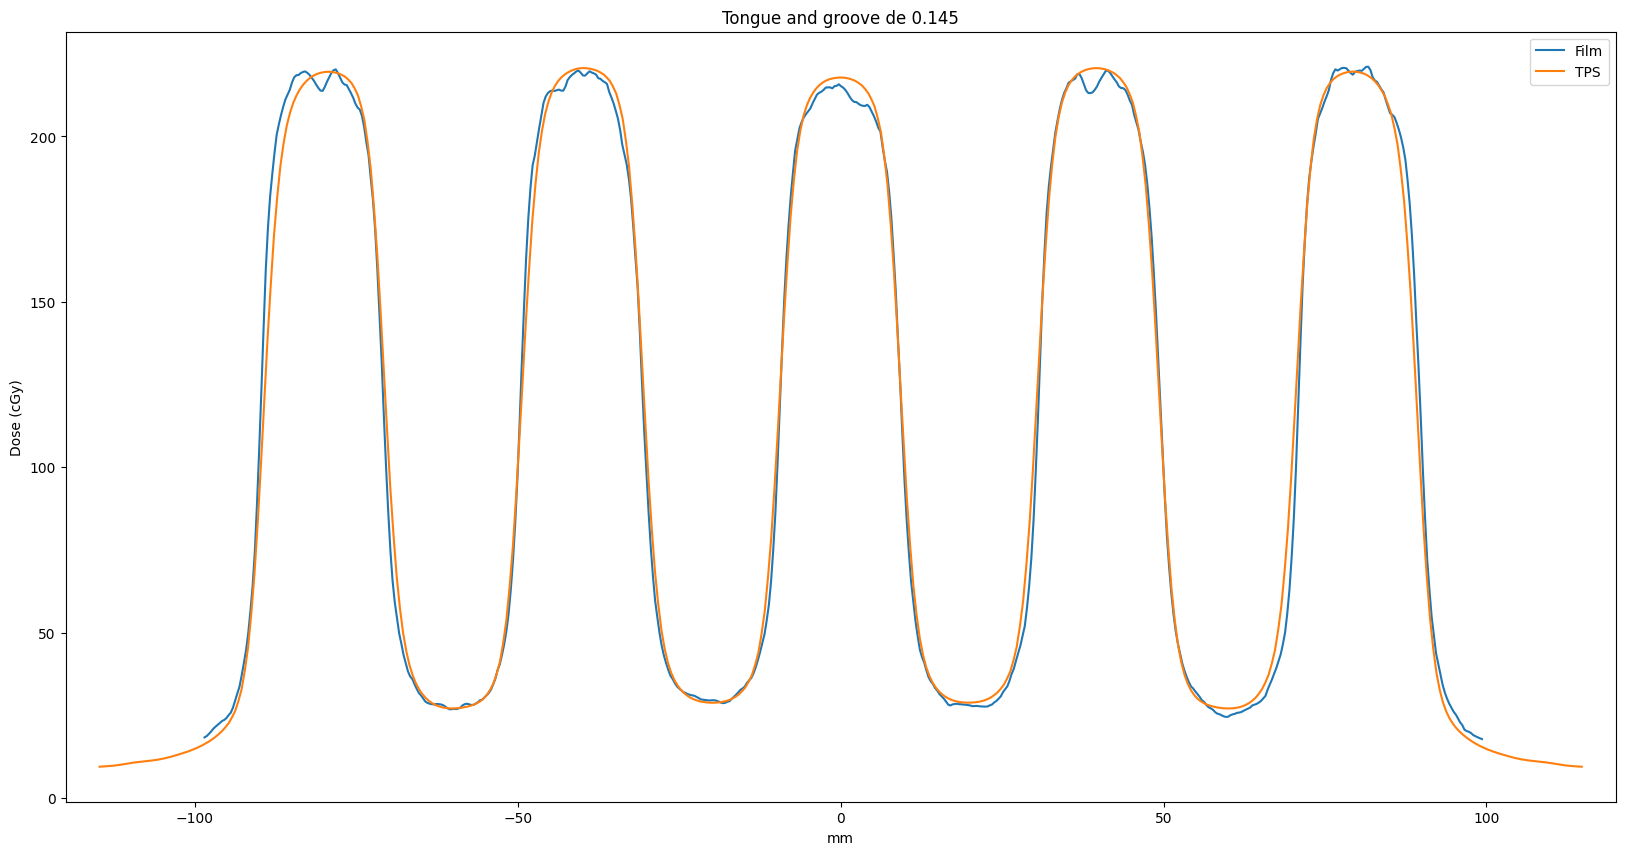

In [10]:
test_planardose()

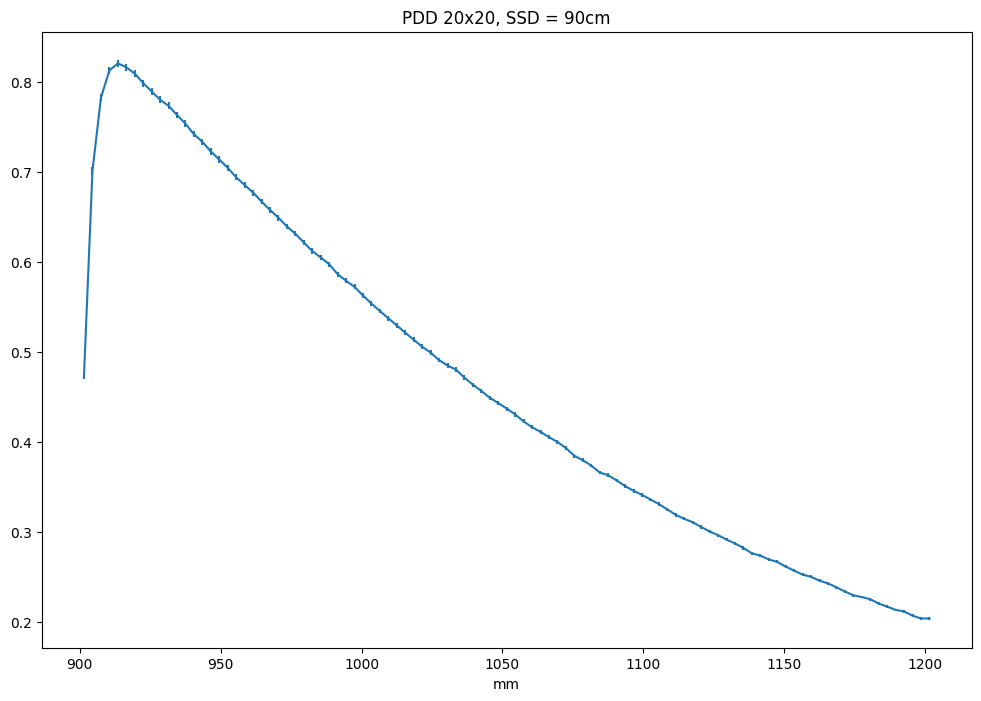

In [11]:
test_dosematrix()